In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
def computeInterCluster(R):
    iloczynySkalarne = -2*np.dot(R.T, R)
    kwadratyDlugosci = np.sum(R**2, axis=0, keepdims=True)
    iloczynySkalarne += kwadratyDlugosci
    iloczynySkalarne += kwadratyDlugosci.T

    return iloczynySkalarne

def computeIntraClusterDistances(data, C, R, I, K, N):
    swojeCentra = np.take(R, C, axis=1)
    swojeCentra -= data
    swojeCentra **= 2

    intraClusterDistances = np.sqrt(np.sum(swojeCentra, axis=0, keepdims=True))

    liczebnosc = np.zeros(K)
    intraAvg = np.zeros(K)
    intraMax = np.zeros(K)
    
    for i in range(N):
        intraAvg[C[i]] += intraClusterDistances[0][i]
        intraMax[C[i]] = max(intraClusterDistances[0][i], intraMax[C[i]])
        liczebnosc[C[i]] += 1
    
    intraAvg /= np.maximum(liczebnosc, 1)
    
    return (intraAvg, intraMax)
        
    

def KMeans(K, data, printInfo=False):
    d = np.size(data, axis=0)
    N = np.size(data, axis=1)
    I = np.eye(K)
    
    #Centra grup (losowe wektory z danych)
    #R = np.take(data, np.random.choice(np.arange(0,N), K, replace=False), axis=1)
    R = np.empty([d,K])
    choices = np.random.choice(np.arange(0,N), K, replace=False)
    for i in range(K):
        R[:,i] = data[:, choices[i]]
    #Przynależnosc do grupy (na poczatku wszyscy do zero)
    C = np.zeros((1,N), dtype=np.int64)
    macierPrzynaleznosci = None

    iteration = 0
    groupsChanged = True
    while groupsChanged:
        iteration += 1
        #Interesuje nas minimalna wartość <r,r> -2<u,r>, gdzie u to wektor z danych a r to jakies centrum
        iloczynySkalarne = -2. * np.dot(data.T, R)
        R**=2
        kwadratyDlugosciR = np.sum(R, axis=0, keepdims=True)
        iloczynySkalarne += kwadratyDlugosciR

        #Dla kazdego wektora z danych wybieramy najblizszy wektor z R i aktualizujemy grupy
        newC = np.argmin(iloczynySkalarne, axis=1)
        groupsChanged = not np.array_equal(C, newC)
        C = newC

        #Obliczamy srodki ciezkosci dla kazdej grupy
        macierzPrzynaleznosci = np.take(I, C, axis=0)
        #Sumy danych w każdej z grup
        R = np.dot(data, macierzPrzynaleznosci)
        liczebnosciGrup = np.maximum(np.sum(macierzPrzynaleznosci, axis=0, keepdims=True), 1)
        R /= liczebnosciGrup

    #Liczymy wielkosci grup, odleglosci miedzy grupami, srednie i najwieksze odleglosci w grupach
    groupSizes = np.sum(macierzPrzynaleznosci, axis=0).astype(np.int64)
    interCluster = computeInterCluster(R)
    intraClusterAvg, intraClusterMax = computeIntraClusterDistances(data, C, R, I, K, N)
    
    if printInfo:
        print("Iterations:", iteration, "\n")
        print("Group sizes:\n", groupSizes, "\n")
        print("Inter cluster distances:")
        print(interCluster, "\n")
        print("Intra cluster average distance to center\n", intraClusterAvg, "\n")
        print("Intra cluster maximum distance to center\n", intraClusterMax, "\n")
    
    return (C, R, interCluster, intraClusterAvg, intraClusterMax)

In [3]:
def generateData(N,d,K,p,mi,sigma):
    L = [np.linalg.cholesky(sigma[i]) for i in range(len(sigma))]
    choices = np.random.choice(np.arange(0,K), N, p=p)
    data = np.random.randn(d,N)
    
    #Jeśli X ~ N(mi, sigma) oraz Y = c + B*X, 
    #to Y ~ N(c + B * mi, B*sigma*B^T)
    #Jak wezmę X ~ N(zeros, I), c = mi oraz B = L, 
    #gdzie sigma = L*L^T, to otrzymam Y ~ N(mi + L*zeros, L*I*L^T) =
    # N(mi, L*L^T) = N(mi, sigma)
    
    for i in range(N):
        data[:,i] = mi[:,choices[i]] + np.dot(L[choices[i]], data[:,i])
        
    return data

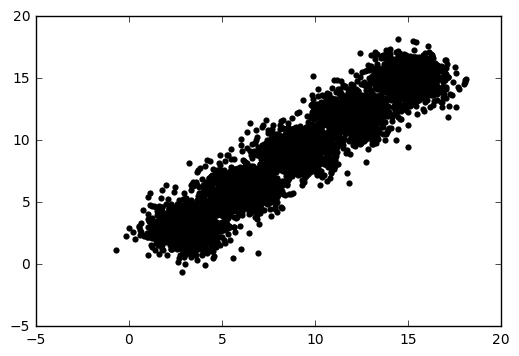

Iterations: 12 

Inter cluster distances:
[[  7.10542736e-15   1.82460091e+01   7.16922153e+01   2.88140869e+02
    1.61742220e+02]
 [  1.82460091e+01   0.00000000e+00   1.76041399e+01   1.61391113e+02
    7.13471623e+01]
 [  7.16922153e+01   1.76041399e+01   0.00000000e+00   7.23967775e+01
    1.80725838e+01]
 [  2.88140869e+02   1.61391113e+02   7.23967775e+01   0.00000000e+00
    1.81261483e+01]
 [  1.61742220e+02   7.13471623e+01   1.80725838e+01   1.81261483e+01
    0.00000000e+00]] 

Intra cluster average distance to center [ 1.28146711  1.21907936  1.20129799  1.22244511  1.22361758] 

Intra cluster maximum distance to center [ 4.42926264  3.51233736  3.76980543  3.77130616  3.97243949] 



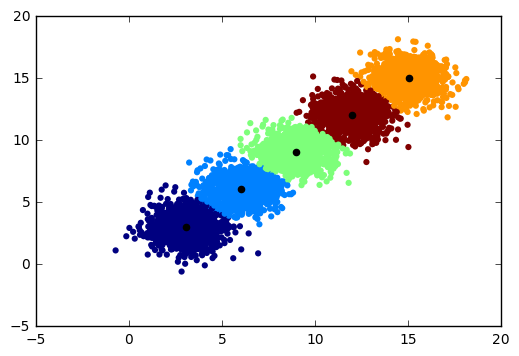

In [4]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

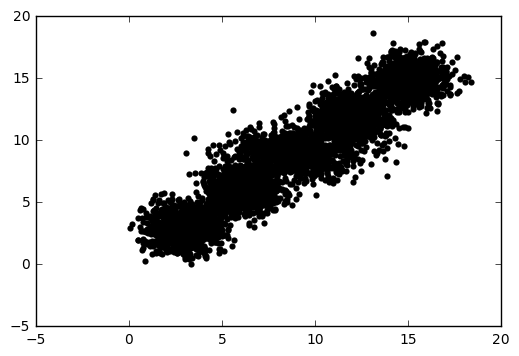

Iterations: 6 

Inter cluster distances:
[[  0.00000000e+00   1.65768666e+01   1.58569957e+02   6.82220928e+01
    1.93590426e+01]
 [  1.65768666e+01   0.00000000e+00   7.26103428e+01   1.75554771e+01
    7.17636376e+01]
 [  1.58569957e+02   7.26103428e+01  -1.13686838e-13   1.87904788e+01
    2.88731841e+02]
 [  6.82220928e+01   1.75554771e+01   1.87904788e+01   0.00000000e+00
    1.60241727e+02]
 [  1.93590426e+01   7.17636376e+01   2.88731841e+02   1.60241727e+02
    7.10542736e-15]] 

Intra cluster average distance to center [ 1.2828736   1.469417    1.25655215  1.286538    1.26061188] 

Intra cluster maximum distance to center [ 4.82071046  4.81666512  4.14726039  5.09730016  3.4265373 ] 



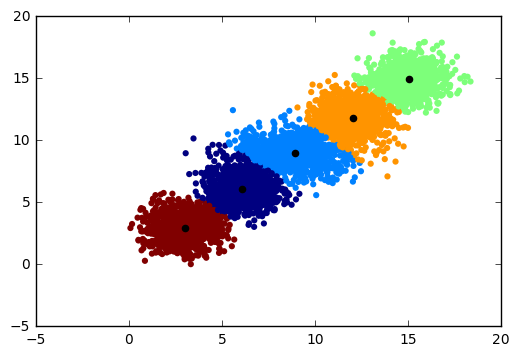

In [5]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

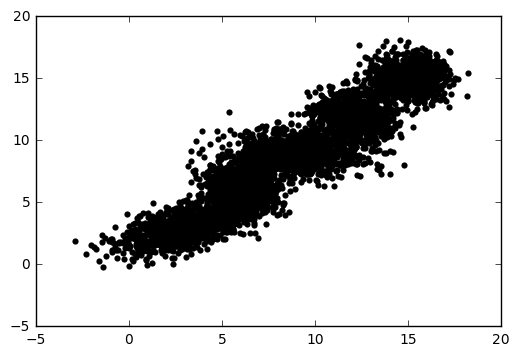

Iterations: 15 

Inter cluster distances:
[[  0.00000000e+00   1.90710536e+01   1.76574816e+01   7.85665264e+01
    7.32929609e+01]
 [  1.90710536e+01   0.00000000e+00   7.33505969e+01   2.02668074e+01
    1.67118603e+02]
 [  1.76574816e+01   7.33505969e+01   0.00000000e+00   1.70680385e+02
    1.90683319e+01]
 [  7.85665264e+01   2.02668074e+01   1.70680385e+02   0.00000000e+00
    3.03616498e+02]
 [  7.32929609e+01   1.67118603e+02   1.90683319e+01   3.03616498e+02
   -1.13686838e-13]] 

Intra cluster average distance to center [ 1.5063196   1.3812814   1.34057039  1.46333361  1.23623532] 

Intra cluster maximum distance to center [ 4.87778491  5.30758582  4.92885694  5.52699443  3.78431015] 



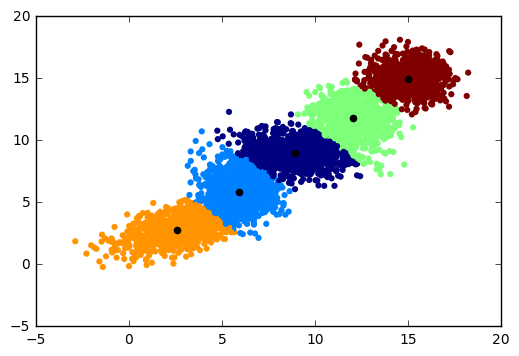

In [6]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[0] = np.array([[3.,1.],[1.,1.]])
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

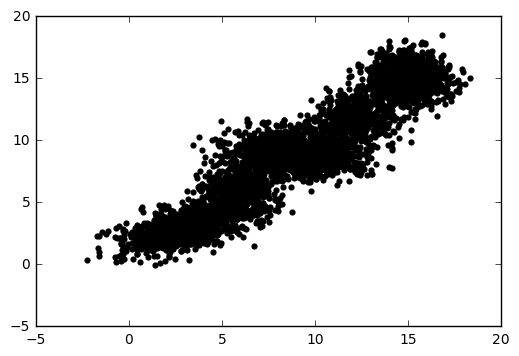

Iterations: 27 

Inter cluster distances:
[[  0.00000000e+00   2.15322928e+01   1.63997839e+01   7.78160975e+01
    7.66943845e+01]
 [  2.15322928e+01   0.00000000e+00   7.42674850e+01   1.77454344e+01
    1.79083093e+02]
 [  1.63997839e+01   7.42674850e+01   0.00000000e+00   1.64533435e+02
    2.30350107e+01]
 [  7.78160975e+01   1.77454344e+01   1.64533435e+02   0.00000000e+00
    3.08982277e+02]
 [  7.66943845e+01   1.79083093e+02   2.30350107e+01   3.08982277e+02
    1.13686838e-13]] 

Intra cluster average distance to center [ 1.49170759  1.5204779   1.57528231  1.39472627  1.21002554] 

Intra cluster maximum distance to center [ 5.1172575   4.77347702  4.10767143  5.2608097   3.93365832] 



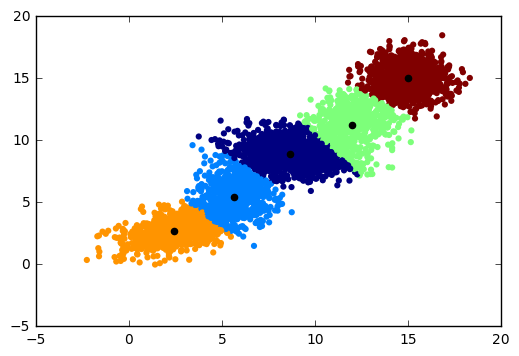

In [7]:
N = 5000
d = 2
K = 5
p = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[0] = np.array([[3.,1.],[1.,1.]])
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

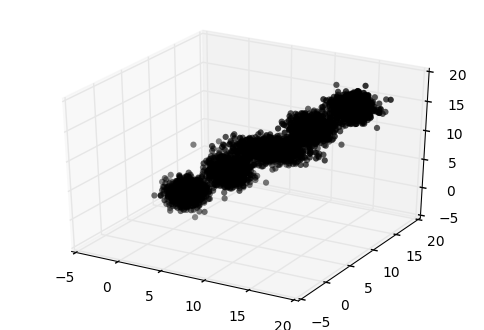

Iterations: 10 

Inter cluster distances:
[[  0.00000000e+00   1.08961749e+02   2.41156600e+02   4.33351656e+02
    2.88525648e+01]
 [  1.08961749e+02  -5.68434189e-14   2.59184749e+01   1.07720487e+02
    2.56966817e+01]
 [  2.41156600e+02   2.59184749e+01   0.00000000e+00   2.79808123e+01
    1.03219967e+02]
 [  4.33351656e+02   1.07720487e+02   2.79808123e+01   0.00000000e+00
    2.38593925e+02]
 [  2.88525648e+01   2.56966817e+01   1.03219967e+02   2.38593925e+02
    0.00000000e+00]] 

Intra cluster average distance to center [ 1.57774117  1.79300883  1.61399129  1.59745085  1.70984833] 

Intra cluster maximum distance to center [ 4.10637359  4.84062153  4.79672536  4.03609053  5.35961111] 



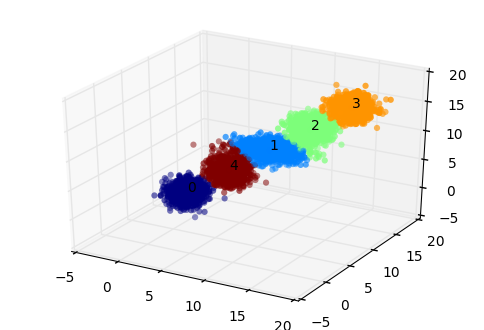

In [8]:
N = 5000
d = 3
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[2] = np.array([[3,1,0],[1,1,0],[0,0,1]], dtype=np.float64)

data = generateData(N,d,K,p,mi,sigma)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0,:], data[1,:], zs=data[2,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0,:], data[1,:], zs=data[2,:], c=groups, marker='o', lw = 0)
ax.scatter(centers[0,:], centers[1,:], zs=centers[2,:], c="Black", marker='o', lw = 1)
for i in range(K):
    ax.text(centers[0,i], centers[1,i], centers[2,i], str(i))
plt.show()

In [9]:
N = 5000
d = 100
K = 10
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]

data = generateData(N,d,K,p,mi,sigma)

startT = time.time()
groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, data, printInfo=True)
endT = time.time()
print("K-Means took %s to compute" % (endT - startT))

Iterations: 13 

Inter cluster distances:
[[ -7.27595761e-12   1.43809721e+04   2.02971653e+03   9.09206349e+02
    2.25351625e+04   5.71287272e+03   2.25100925e+04   5.70727808e+00
    8.09320109e+03   1.44046799e+04]
 [  1.43809721e+04   0.00000000e+00   5.60662079e+03   2.25150246e+04
    7.29144975e+04   3.82169418e+04   7.28692559e+04   1.44413278e+04
    8.97896647e+02   5.75667722e+04]
 [  2.02971653e+03   5.60662079e+03   1.45519152e-11   5.65132765e+03
    3.80844247e+04   1.45483465e+04   3.80519312e+04   2.05332795e+03
    2.01776814e+03   2.72433420e+04]
 [  9.09206349e+02   2.25150246e+04   5.65132765e+03   0.00000000e+00
    1.43954028e+04   2.06525825e+03   1.43759859e+04   8.95671908e+02
    1.44220322e+04   8.07906770e+03]
 [  2.25351625e+04   7.29144975e+04   3.80844247e+04   1.43954028e+04
    4.54747351e-13   5.55637045e+03   5.43989006e+00   2.24616262e+04
    5.76328484e+04   9.06997048e+02]
 [  5.71287272e+03   3.82169418e+04   1.45483465e+04   2.06525825e+03
   